In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import keras_cv


BATCH_SIZE = 4
GLOBAL_CLIPNORM = 10.0

AUTO = tf.data.AUTOTUNE

c:\Users\ghars\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')
    
    boxes = []
    classes = []
    
    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])
        
            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])
            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)
    
            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)
    
    return img_path, classes, boxes


# a function for creating file paths list 
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


class_ids = ['label0', 'label1', 'label2']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

class_mapping


{0: 'label0', 1: 'label1', 2: 'label2'}

In [3]:
def creating_files(img_files_paths, annot_files_paths):
    
    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)
    
    image_paths = []
    bbox = []
    classes = []
    
    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)
        
    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    
    return image_paths, classes, bbox

In [4]:
train_img_paths, train_classes, train_bboxes = creating_files(r'E:\Python\rain\BrainTumorDetection\train\images', 
                                                              r'E:\Python\rain\BrainTumorDetection\train\labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files(r'E:\Python\rain\BrainTumorDetection\valid\images', 
                                                              r'E:\Python\rain\BrainTumorDetection\valid\labels')

test_img_paths, test_classes, test_bboxes = creating_files(r'E:\Python\rain\BrainTumorDetection\test\images', 
                                                            r'E:\Python\rain\BrainTumorDetection\test\labels')

In [5]:
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32) 
    
    return img


resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }
    
    return {"images": img, "bounding_boxes": bounding_boxes}
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


In [6]:
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [7]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

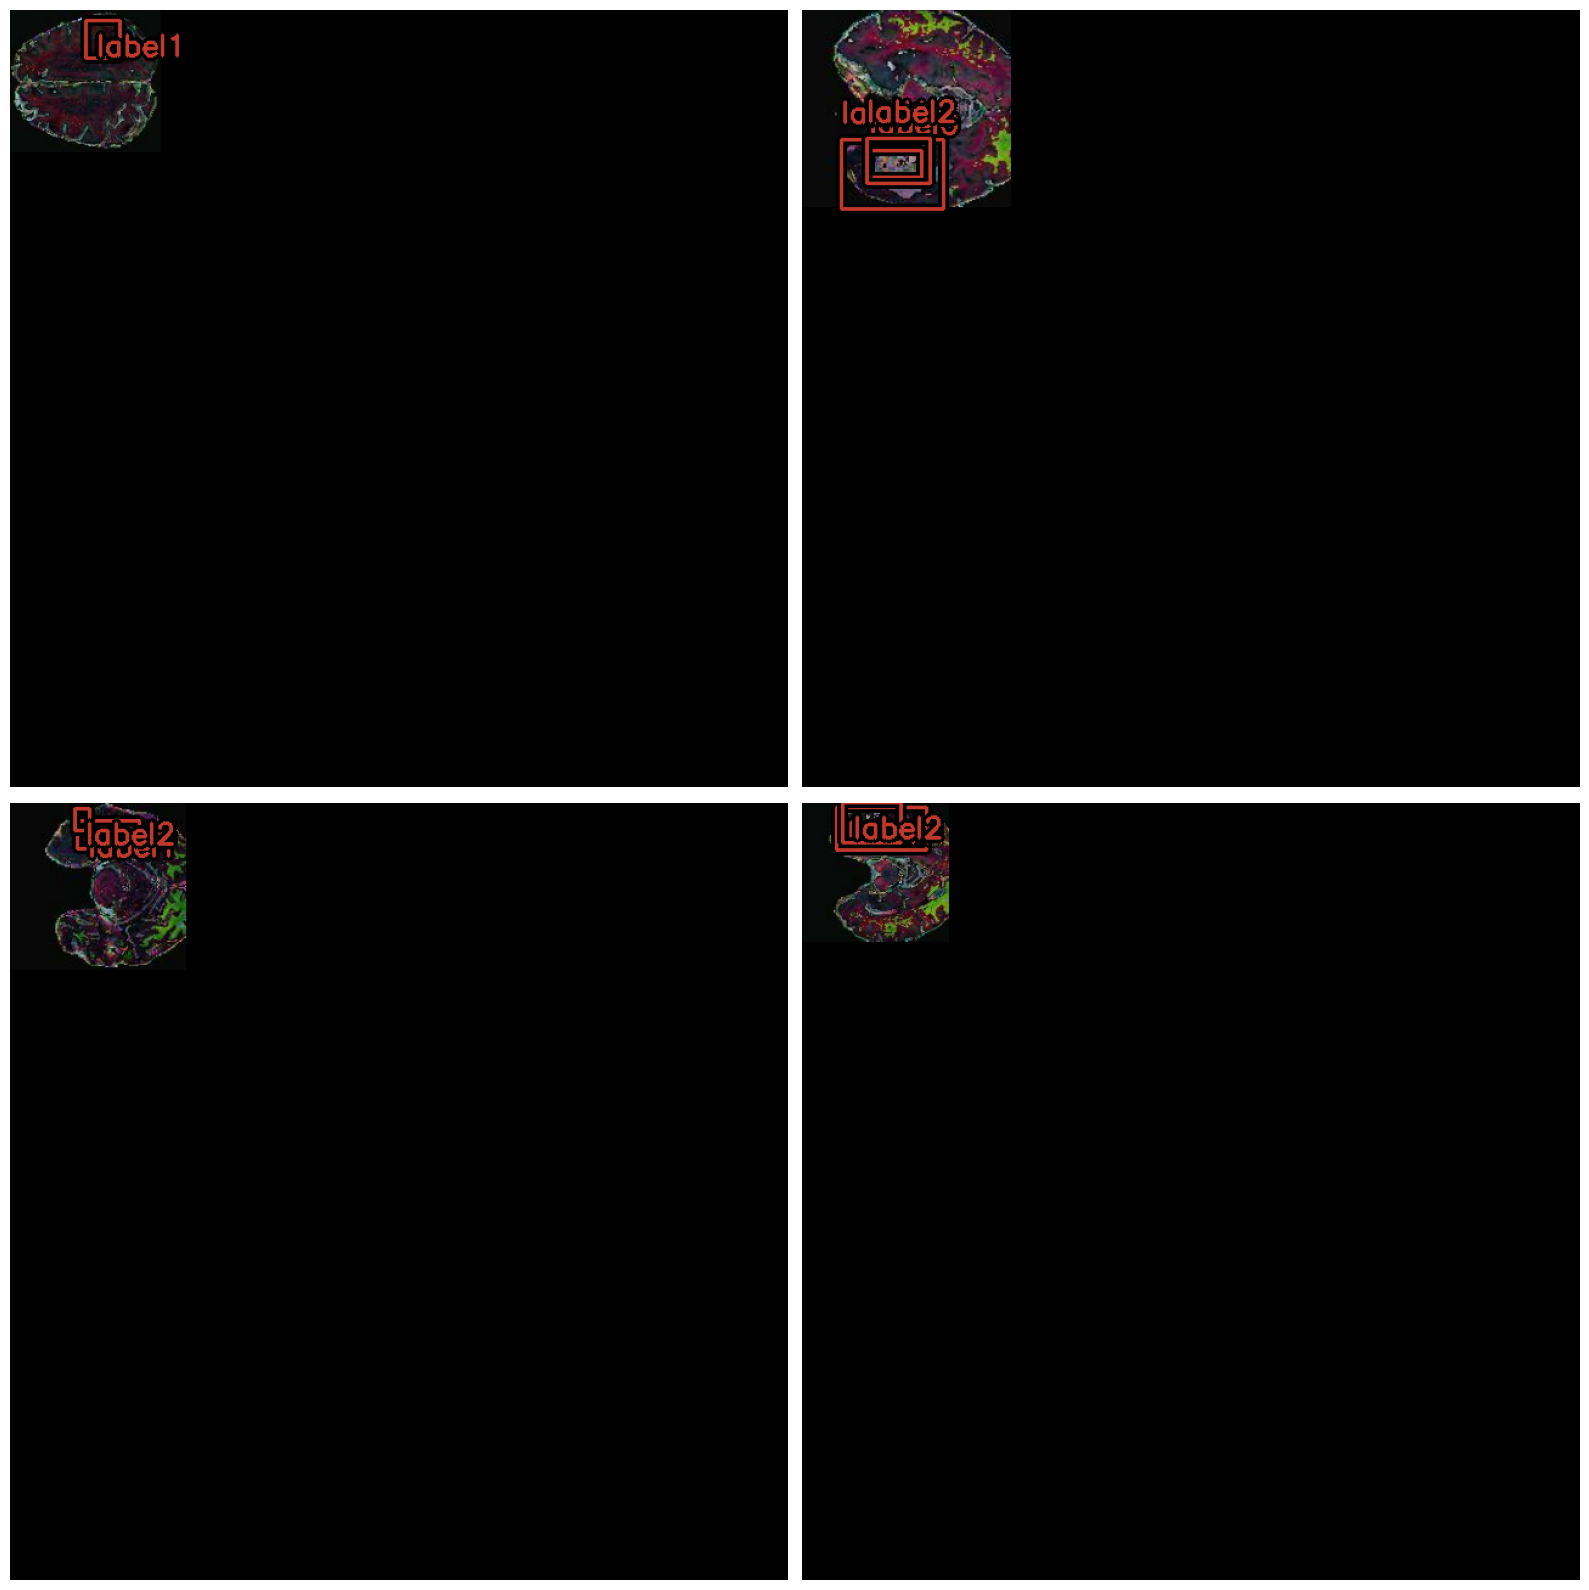

In [8]:
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

In [9]:
stg = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [10]:
with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")
    
    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                              bounding_box_format="xyxy",
                                              backbone=backbone, fpn_depth=1 )

    optimizer = AdamW(learning_rate=0.0001, weight_decay=0.004, global_clipnorm = GLOBAL_CLIPNORM)

    YOLOV8_model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')

100%|██████████| 645/645 [00:00<?, ?B/s] 
100%|██████████| 5.11M/5.11M [00:17<00:00, 310kB/s]


In [13]:
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,  epochs = 10)

Epoch 1/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1740s 1s/step - loss: 2.2013 - val_loss: 2.4747
Epoch 2/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1732s 999ms/step - loss: 2.1805 - val_loss: 2.4424
Epoch 3/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1721s 993ms/step - loss: 2.1465 - val_loss: 2.4166
Epoch 4/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1730s 998ms/step - loss: 2.0966 - val_loss: 2.4437
Epoch 5/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1733s 1s/step - loss: 2.0688 - val_loss: 2.3853
Epoch 6/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1628s 940ms/step - loss: 2.0378 - val_loss: 2.3527
Epoch 7/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1663s 960ms/step - loss: 2.0157 - val_loss: 2.3386
Epoch 8/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1778s 1s/step - loss: 1.9768 - val_loss: 2.3505
Epoch 9/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1788s 1s/step - loss: 1.9620 - val_loss: 2.3078
Epoch 10/10
1732/1732 ━━━━━━━━━━━━━━━━━━━━ 1831s 1s/step - loss: 1.9322 - val_loss: 2.3136


In [24]:
def visualize_predict_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
        
    y_pred = model.predict(images)
    #y_pred = keras_cv.bounding_box.to_ragged(y_pred)
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping,
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


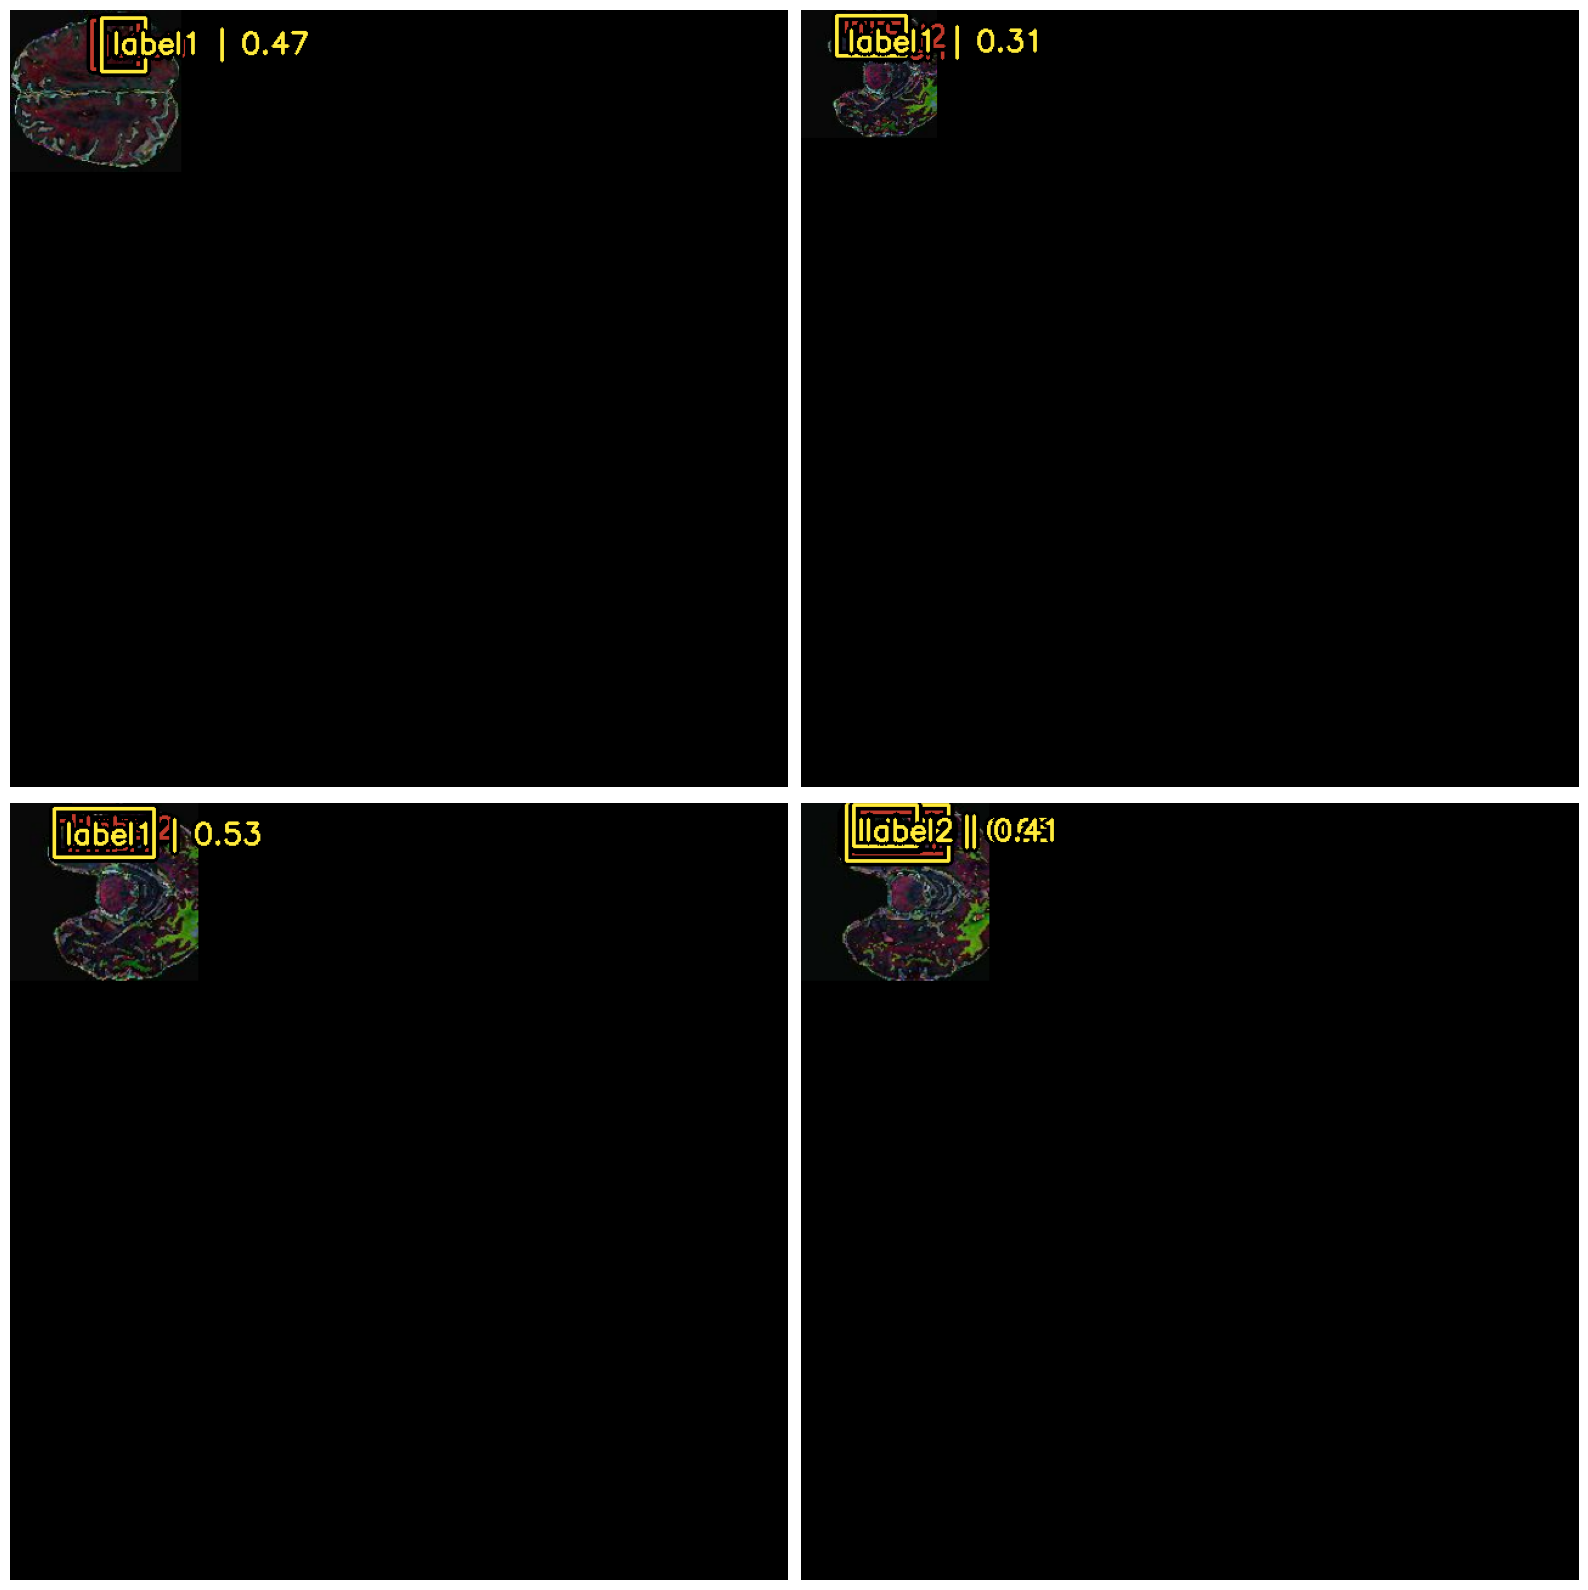

In [25]:
visualize_predict_detections(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")